In [288]:
import yfinance as yf
from prophet import Prophet
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import seaborn as sns
from pypfopt import EfficientFrontier, risk_models, expected_returns
import json

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

np.random.seed(42)  # for reproducibility

PERIOD = '10y'
TICKERS = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'TSLA', 'NVDA', 'PLTR', 'ADBE', 'INTC']
TICKER = 'AAPL'
START_DATE = '2021-01-01'

In [289]:
def fetch_yfinance_data(ticker, period=PERIOD):
    stock = yf.Ticker(ticker)
    data = stock.history(period=period)
    df = pd.DataFrame(data)
    df.reset_index(inplace=True)
    # Handle missing values
    df['Close'] = df['Close'].ffill()  # or 'bfill', or interpolate
    return df

# Example:
df = fetch_yfinance_data(TICKER)
#print(df.head())

In [290]:
def decompose_stock(df, ds_column='Date', y_column='Close'):
    # Ensure 'Date' column does not have timezone information
    df[ds_column] = pd.to_datetime(df[ds_column]).dt.tz_localize(None)
    
    df = df.rename(columns={ds_column: 'ds', y_column: 'y'})
    model = Prophet()
    model.fit(df)
    future = model.make_future_dataframe(periods=0)
    forecast = model.predict(future)
    
    trend = forecast[['ds', 'trend']]
    
    # Check for existing seasonality components
    seasonality_columns = ['yearly', 'weekly', 'daily']
    seasonality_columns = [col for col in seasonality_columns if col in forecast.columns]
    seasonality = forecast[['ds'] + seasonality_columns] if seasonality_columns else None
    
    noise = df['y'] - forecast['yhat']
    
    return trend, seasonality, noise

# Example:
trend, seasonality, noise = decompose_stock(df)

21:23:49 - cmdstanpy - INFO - Chain [1] start processing
21:23:49 - cmdstanpy - INFO - Chain [1] done processing


In [291]:
def analyze_stock(df):
    df['returns'] = df['Close'].pct_change()
    volatility = df['returns'].std() * np.sqrt(252)  # annualized
    
    return {
        'returns': df['returns'],
        'volatility': volatility
    }

# Example:
analysis = analyze_stock(df)

In [292]:
def model_evaluation(df, target_col='Close', test_size=0.2):
    df = df.set_index('Date')
    train = df.iloc[:-int(len(df) * test_size)]
    test = df.iloc[-int(len(df) * test_size):]
    
    # ARIMA
    arima_model = ARIMA(train[target_col], order=(1,1,1))
    arima_results = arima_model.fit()
    arima_pred = arima_results.forecast(steps=len(test))
    
    # Prophet
    prophet_df = train.reset_index().rename(columns={'Date': 'ds', target_col: 'y'})
    prophet_model = Prophet().fit(prophet_df)
    prophet_future = prophet_model.make_future_dataframe(periods=len(test))
    prophet_forecast = prophet_model.predict(prophet_future)
    prophet_pred = prophet_forecast['yhat'].tail(len(test))
    
    # XGBoost
    X_train = train.index.to_julian_date().values.reshape(-1, 1)
    X_test = test.index.to_julian_date().values.reshape(-1, 1)
    y_train, y_test = train[target_col].values, test[target_col].values
    xgb_model = XGBRegressor().fit(X_train, y_train)
    xgb_pred = xgb_model.predict(X_test)

    metrics = {
        'RMSE': lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error,
        'MAPE': lambda y_true, y_pred: np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    }
    
    results = {}
    for model_name, pred in zip(['ARIMA', 'Prophet', 'XGBoost'], [arima_pred, prophet_pred, xgb_pred]):
        results[model_name] = {metric: func(y_test, pred) for metric, func in metrics.items()}
    
    return results

# Example:
results = model_evaluation(df)
#print(pd.DataFrame(results))
#print(pd.DataFrame(results).min(axis=1))

21:23:50 - cmdstanpy - INFO - Chain [1] start processing
21:23:50 - cmdstanpy - INFO - Chain [1] done processing


In [293]:
def trading_strategy(df, rf_rate=0.02):  # Assume T-bill rate for simplicity
    strategy_returns = df['returns']  # Example strategy: just use stock returns
    sharpe = (strategy_returns.mean() * 252 - rf_rate) / (strategy_returns.std() * np.sqrt(252))
    sortino = (strategy_returns.mean() * 252 - rf_rate) / (strategy_returns[strategy_returns < 0].std() * np.sqrt(252))
    
    cumulative = (1 + strategy_returns).cumprod()
    max_drawdown = (cumulative / cumulative.cummax() - 1).min()
    
    return {
        'Sharpe Ratio': sharpe,
        'Sortino Ratio': sortino,
        'Max Drawdown': max_drawdown
    }

# Example:
metrics = trading_strategy(df)
#print(metrics)

In [294]:
def multi_stock_analysis(tickers, period=PERIOD):
    # Create dictionaries to store DataFrames and results
    stock_data = {}
    results = {}
    
    # Fetch and store data for all tickers
    for ticker in tickers:
        df = fetch_yfinance_data(ticker, period)
        stock_data[ticker] = df
        analysis = analyze_stock(df)
        strategy_metrics = trading_strategy(df)
        
        results[ticker] = {
            'volatility': float(analysis['volatility']),  # Convert to float for consistency
            **strategy_metrics
        }
    
    # Create price DataFrame for portfolio optimization
    prices_df = pd.DataFrame({ticker: data['Close'] for ticker, data in stock_data.items()})
    
    # Calculate correlation matrix
    correlation_matrix = prices_df.corr()
    
    # Portfolio optimization
    try:
        mu = expected_returns.mean_historical_return(prices_df, frequency=252)  # Assuming daily data
        S = risk_models.sample_cov(prices_df)
        ef = EfficientFrontier(mu, S, weight_bounds=(0, 1))
        weights = ef.max_sharpe()
        cleaned_weights = ef.clean_weights()
    except Exception as e:
        print(f"Portfolio optimization failed: {str(e)}")
        cleaned_weights = {ticker: 1/len(tickers) for ticker in tickers}  # Equal weights as fallback
    
    # Convert results to DataFrame for easy viewing
    results_df = pd.DataFrame(results).T
    
    # Reorder columns for better readability
    column_order = ['volatility', 'Sharpe Ratio', 'Sortino Ratio', 'Max Drawdown']
    results_df = results_df[column_order]
    
    # Rename columns for better display
    results_df.columns = ['Volatility', 'Sharpe Ratio', 'Sortino Ratio', 'Max Drawdown']
    
    # Format numbers
    results_df = results_df.round(4)
    
    # Add portfolio weights as a new column
    results_df['Portfolio Weight'] = pd.Series(cleaned_weights)
    
    return results_df, correlation_matrix, cleaned_weights

# Example usage:
results_df, correlation_matrix, weights = multi_stock_analysis(TICKERS)

# Print results in a nicely formatted table
print("\nStock Analysis Results:")
print("=" * 80)
print(results_df.to_string())
print("\nCorrelation Matrix:")
print("=" * 80)
print(correlation_matrix.round(3).to_string())


Stock Analysis Results:
       Volatility  Sharpe Ratio  Sortino Ratio  Max Drawdown  Portfolio Weight
AAPL       0.2844        0.8250         1.1387       -0.3852           0.00000
MSFT       0.2701        0.9449         1.3034       -0.3715           0.04285
GOOGL      0.2857        0.7433         1.0231       -0.4432           0.00000
AMZN       0.3249        0.8677         1.2423       -0.5615           0.05297
META       0.3753        0.7308         0.9261       -0.7674           0.00000
TSLA       0.5737        0.8195         1.2091       -0.7363           0.01533
NVDA       0.4910        1.3407         1.9816       -0.6634           0.58033
PLTR       0.7225        1.1352         2.0279       -0.8462           0.30852
ADBE       0.3317        0.6458         0.8102       -0.6002           0.00000
INTC       0.3634        0.1368         0.1732       -0.6957           0.00000

Correlation Matrix:
        AAPL   MSFT  GOOGL   AMZN   META   TSLA   NVDA   PLTR   ADBE   INTC
AAPL   1.

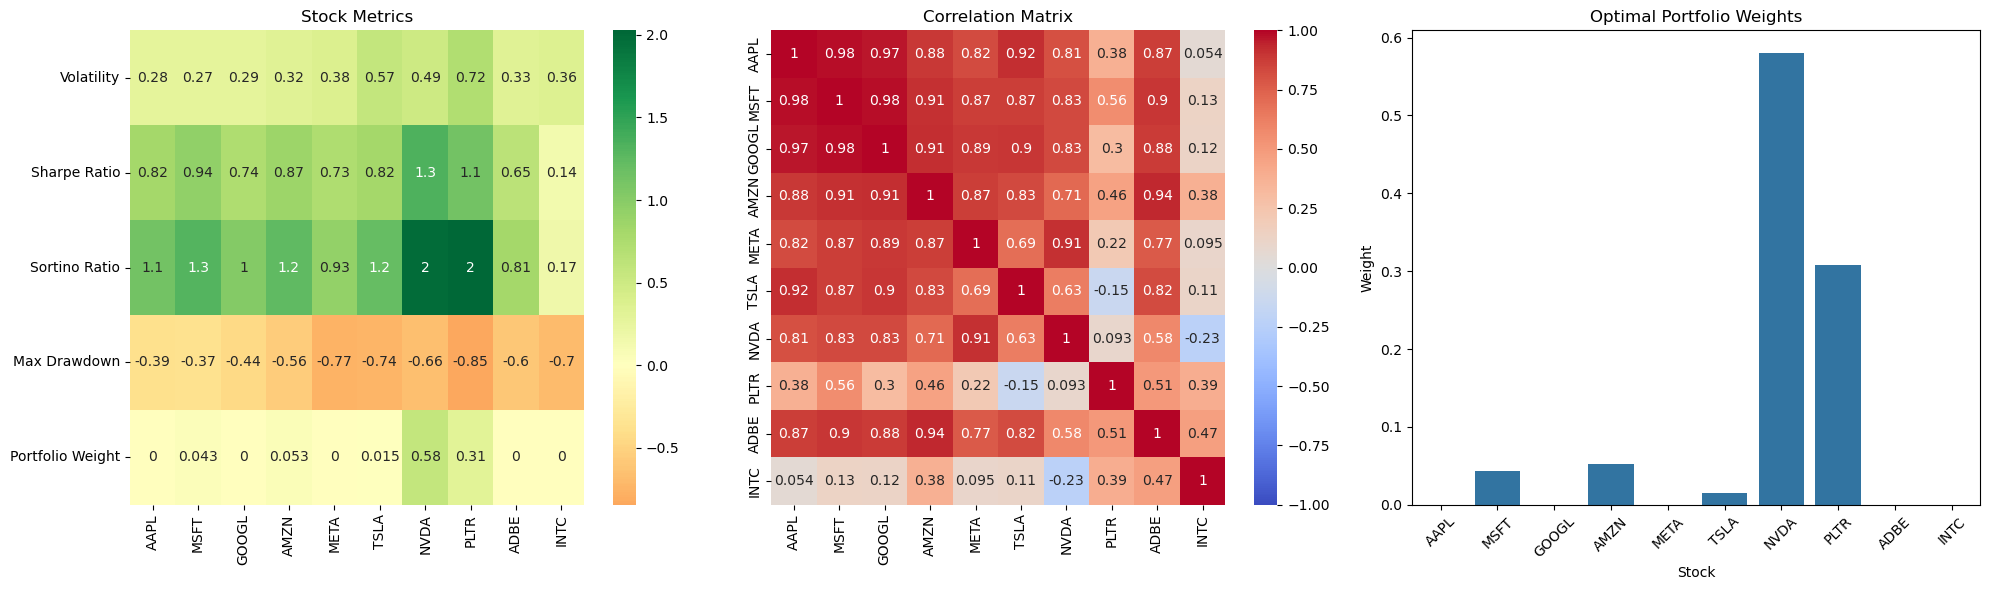


Detailed Results:
       Volatility  Sharpe Ratio  Sortino Ratio  Max Drawdown  Portfolio Weight
AAPL       0.2844        0.8250         1.1387       -0.3852            0.0000
MSFT       0.2701        0.9449         1.3034       -0.3715            0.0428
GOOGL      0.2857        0.7433         1.0231       -0.4432            0.0000
AMZN       0.3249        0.8677         1.2423       -0.5615            0.0530
META       0.3753        0.7308         0.9261       -0.7674            0.0000
TSLA       0.5737        0.8195         1.2091       -0.7363            0.0153
NVDA       0.4910        1.3407         1.9816       -0.6634            0.5803
PLTR       0.7225        1.1352         2.0279       -0.8462            0.3085
ADBE       0.3317        0.6458         0.8102       -0.6002            0.0000
INTC       0.3634        0.1368         0.1732       -0.6957            0.0000


In [295]:
def plot_portfolio_analysis(results, correlation_matrix, weights):
    # Create a figure with 3 subplots
    fig = plt.figure(figsize=(20, 6))
    
    # 1. Stock Metrics Plot
    ax1 = plt.subplot(131)
    metrics_df = pd.DataFrame(results).T
    sns.heatmap(metrics_df, annot=True, cmap='RdYlGn', center=0, ax=ax1)
    ax1.set_title('Stock Metrics')
    
    # 2. Correlation Matrix Plot
    ax2 = plt.subplot(132)
    sns.heatmap(correlation_matrix, 
                annot=True, 
                cmap='coolwarm', 
                center=0,
                vmin=-1, vmax=1,
                ax=ax2)
    ax2.set_title('Correlation Matrix')
    
    # 3. Portfolio Weights Plot
    ax3 = plt.subplot(133)
    weights_series = pd.Series(weights)
    sns.barplot(x=weights_series.index, y=weights_series.values, ax=ax3)
    ax3.set_title('Optimal Portfolio Weights')
    ax3.set_ylabel('Weight')
    ax3.set_xlabel('Stock')
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

# Example usage:
results, correlation, weights = multi_stock_analysis(TICKERS)
plot_portfolio_analysis(results, correlation, weights)

# Print numerical results if needed
print("\nDetailed Results:")
print("=" * 80)
print(results.to_string(index=True, float_format='{:,.4f}'.format))